In [53]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

Data processing with vaccine info

In [45]:
df_trend = pd.read_csv(os.path.join(data_dir, "train_trendency.csv"), index_col=0)
df_vaccine = pd.read_csv(os.path.join(data_dir, "train_vaccine.csv"), index_col=0)

In [46]:
df_trend['Date'] = pd.to_datetime(df_trend['Date'])
df_vaccine['date'] = pd.to_datetime(df_vaccine['date'])
df_trend = df_trend.rename(columns={'Province_State':'location','Date':'date'})

In [66]:
merged_df = pd.merge(df_vaccine, df_trend, on=['date','location'])

SAME data processing as starter.ipynb

In [87]:
data_dir = os.path.join(os.getcwd(), "ucla-covid19-prediction")
dataset = pd.read_csv(os.path.join(data_dir, "train_trendency.csv"), index_col=0)
test_dataset = pd.read_csv(os.path.join(data_dir, "test_data.csv"), index_col=0)
dataset["Date"] = dataset["Date"].map(lambda date: date[:5])

ARIMA model. Source https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [239]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Use California to observe and choose overall ARIMA parameters.

In [374]:
state = 'California'
state_dataset = dataset[dataset["Province_State"] == state]
state_series = state_dataset.set_index('Date')
X = state_series.drop(
    columns=["Recovered", "Active", "Province_State", "Confirmed", "Deaths"])
y = state_series['Confirmed']
z = state_series['Deaths']

Determine d ("minimum differencing required to get a near-stationary mean")

In [375]:
# null hypothesis is that the series is non-stationary
print(adfuller(y)[1])
print(adfuller(y.diff().dropna())[1])
print(adfuller(y.diff().diff().dropna())[1])
print(adfuller(z)[1])
print(adfuller(z.diff().dropna())[1])
print(adfuller(z.diff().diff().dropna())[1])

0.9577195056703641
0.0005889317802270181
0.024632790862079618
2.7712787094519944e-05
0.9302325855307555
1.1909951471769325e-10


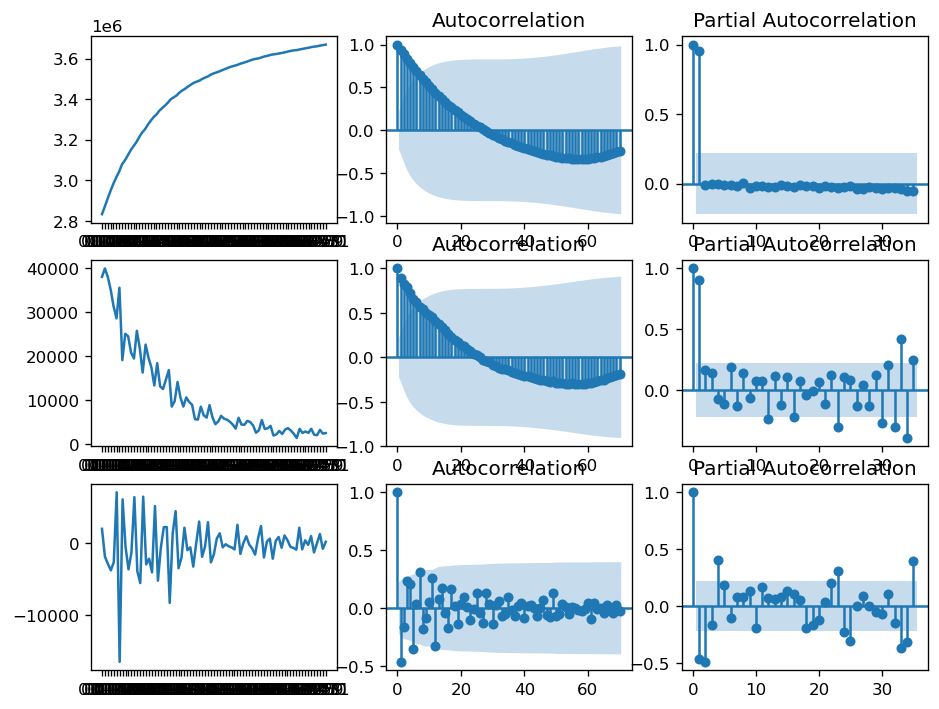

In [376]:
fig, axes = plt.subplots(3, 3)

axes[0,0].plot(y)
plot_acf(y,lags=70, ax=axes[0,1])
plot_pacf(y,lags=35, ax=axes[0,2])

axes[1,0].plot(y.diff().dropna())
plot_acf(y.diff().dropna(),lags=70, ax=axes[1,1])
plot_pacf(y.diff().dropna(),lags=35, ax=axes[1,2])

axes[2,0].plot(y.diff().diff().dropna())
plot_acf(y.diff().diff().dropna(),lags=70, ax=axes[2,1])
plot_pacf(y.diff().diff().dropna(),lags=35, ax=axes[2,2])

plt.show()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


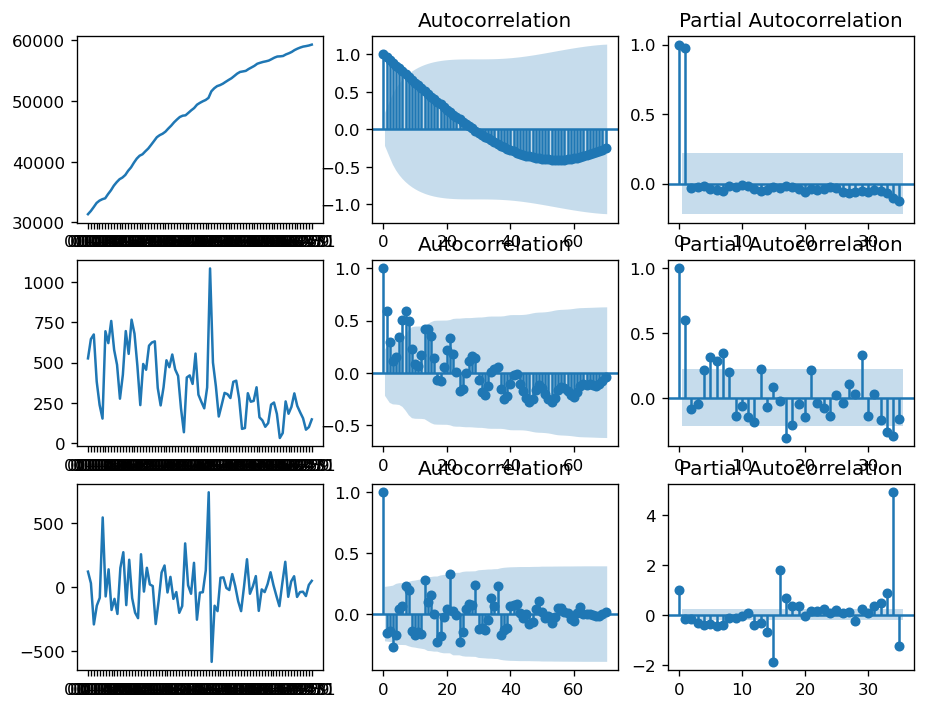

In [377]:
fig, axes = plt.subplots(3, 3)

axes[0,0].plot(z)
plot_acf(z,lags=70, ax=axes[0,1])
plot_pacf(z,lags=35, ax=axes[0,2])

axes[1,0].plot(z.diff().dropna())
plot_acf(z.diff().dropna(),lags=70, ax=axes[1,1])
plot_pacf(z.diff().dropna(),lags=35, ax=axes[1,2])

axes[2,0].plot(z.diff().diff().dropna())
plot_acf(z.diff().diff().dropna(),lags=70, ax=axes[2,1])
plot_pacf(z.diff().diff().dropna(),lags=35, ax=axes[2,2])

plt.show()


In [378]:
cases_model = ARIMA(y, order=(1,1,1))
cases_fit = cases_model.fit()
print(cases_fit.summary())

death_model = ARIMA(z, order=(1,1,1))
death_fit = death_model.fit()
print(death_fit.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                   79
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -709.060
Date:                Sat, 29 May 2021   AIC                           1424.120
Time:                        02:50:59   BIC                           1431.191
Sample:                             0   HQIC                          1426.951
                                 - 79               

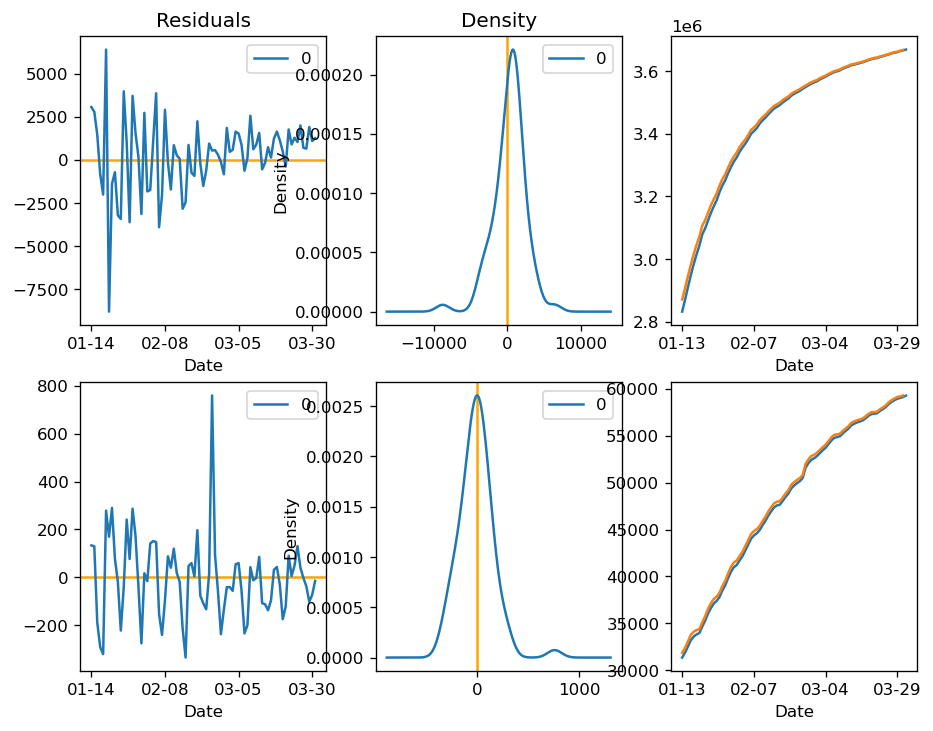

In [379]:
fig, ax = plt.subplots(2,3)
ax[0,0].axhline(0, color='orange')
ax[0,1].axvline(0, color='orange')
ax[1,0].axhline(0, color='orange')
ax[1,1].axvline(0, color='orange')

cases_res = pd.DataFrame(cases_fit.resid[2:])
cases_res.plot(title="Residuals", ax=ax[0,0])
cases_res.plot(kind='kde', title='Density', ax=ax[0,1])
y.plot(ax=ax[0,2])
cases_fit.predict()[1:].plot(ax=ax[0,2])

death_res = pd.DataFrame(death_fit.resid[2:])
death_res.plot(ax=ax[1,0])
death_res.plot(kind='kde', ax=ax[1,1])
z.plot(ax=ax[1,2])
death_fit.predict()[1:].plot(ax=ax[1,2])

plt.show()

Out-of-time CV

In [511]:
cases_train = y[:60]
cases_test = y[60:]

cases_model_cv = ARIMA(cases_train, order=(1,1,1))
cases_fit_cv = cases_model_cv.fit()
cases_pred = cases_fit_cv.forecast(steps=19)

death_train = z[:60]
death_test = z[60:]

death_model_cv = ARIMA(death_train, order=(1,1,1))
death_fit_cv = death_model_cv.fit()
death_pred = death_fit_cv.forecast(steps=19)

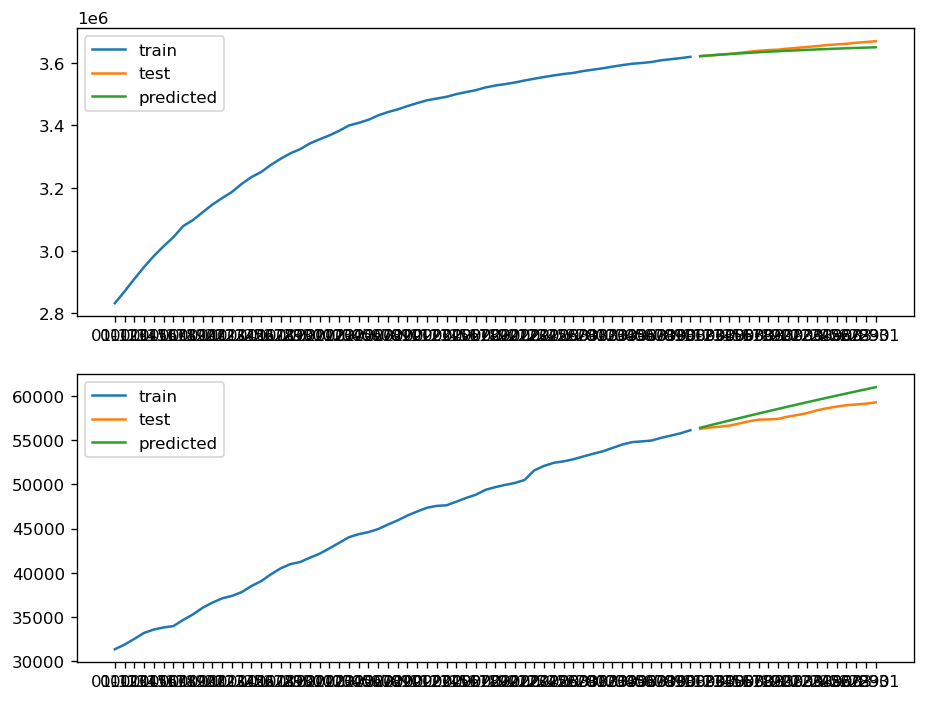

In [512]:
fig, ax = plt.subplots(2)

ax[0].plot(cases_train, label='train')
ax[0].plot(cases_test, label='test')
ax[0].plot(cases_pred, label='predicted')
ax[0].legend(loc='upper left')

ax[1].plot(death_train, label='train')
ax[1].plot(death_test, label='test')
ax[1].plot(death_pred, label='predicted')
ax[1].legend(loc='upper left')

plt.show()